In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve, fbeta_score, precision_score,recall_score, PrecisionRecallDisplay, f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer


from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier





In [15]:

data = pd.read_csv("credit_risk_dataset.csv")

#Разведочный анализ данных

In [16]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


<Axes: >

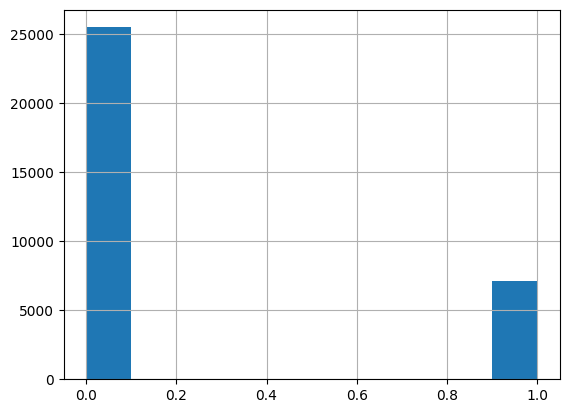

In [18]:
data['loan_status'].hist()

In [19]:
data['loan_status'].value_counts()

loan_status
0    25473
1     7108
Name: count, dtype: int64

In [20]:
corr = data.select_dtypes(include= [np.number]).corr()

corr['loan_status'].sort_values(ascending=False)

loan_status                   1.000000
loan_percent_income           0.379366
loan_int_rate                 0.335133
loan_amnt                     0.105376
cb_person_cred_hist_length   -0.015529
person_age                   -0.021629
person_emp_length            -0.082489
person_income                -0.144449
Name: loan_status, dtype: float64

<Axes: >

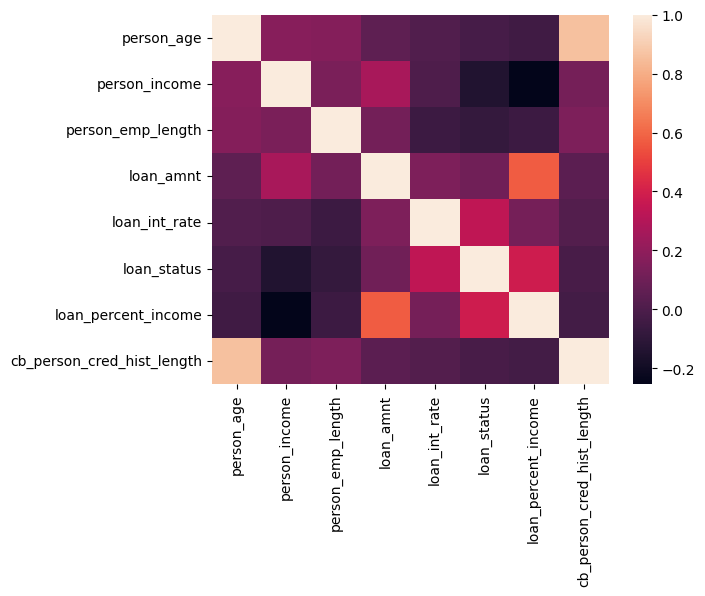

In [21]:
sns.heatmap(corr)

###Обрабатываем данные

In [22]:
X = data.drop(columns=['loan_status'])
y = data['loan_status']
num_cols = X.select_dtypes(include=[np.number]).columns.to_list()
cat_cols = X.select_dtypes(include='object').columns.to_list()



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




In [38]:
num_pipe = Pipeline([
    ('impute',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

catboost_model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', SMOTE(random_state=42)),
    ('modell', CatBoostClassifier(
        learning_rate=0.08,
        l2_leaf_reg=3,
        iterations=1000,
        depth=8,
        random_seed=42,
        verbose=100
    ))
])

lgbm_model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', SMOTE(random_state=42)),
    ('modell', LGBMClassifier(
        subsample=0.6,
        reg_lambda=0,
        reg_alpha=0,
        num_leaves=31,
        n_estimators=800,
        min_child_samples=10,
        max_depth=5,
        learning_rate=0.1,
        colsample_bytree=0.6,
        random_state=42
    ))
])

log_model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', SMOTE(random_state=42)),
    ('modell', LogisticRegression(
    C=1.0,
    max_iter=1000,
    random_state=42
))
])


rf_model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', SMOTE(random_state=42)),
    ('modell', RandomForestClassifier(
        max_depth=8,
        min_samples_leaf=2,
        min_samples_split=5,
        n_estimators=100,
        random_state=42
    ))
])
gradient_model = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state = 42)),
    ('modell', GradientBoostingClassifier(subsample = 1.0,
                                            n_estimators = 300,
                                            min_samples_split = 2,
                                            min_samples_leaf = 5,
                                            max_depth=  4,
                                            learning_rate = 0.1))
])

Проанализировав определённые модели и подобрав лучшие параметры, делаю стекинг

In [ ]:
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier


estimators = [
    ('lgbm', lgbm_model),
    ('catboost', catboost_model),
    ('log', log_model)
]
final_estimator = GradientBoostingClassifier(subsample = 1.0,
                                            n_estimators = 300,
                                            min_samples_split = 2,
                                            min_samples_leaf = 5,
                                            max_depth=  4,
                                            learning_rate = 0.1)

# Сам стекинг
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1,
    stack_method='predict_proba'  # чтобы использовать вероятности
)

stacking_model.fit(X_train, y_train)


,estimators,"[('lgbm', ...), ('catboost', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,False
,verbose,0
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None


In [40]:
from sklearn.metrics import auc
predict = stacking_model.predict(X_test)

print(f1_score(y_test, predict))
print(recall_score(y_test, predict))
print(precision_score(y_test, predict))


0.8351126927639383
0.7426160337552743
0.9539295392953929


c:\Users\Даниэль\Desktop\Credit-scoring\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [26]:

from sklearn.calibration import CalibratedClassifierCV

calibrated = CalibratedClassifierCV(estimator=stacking_model, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)
y_proba_valid = calibrated.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_valid)

fbeta_scores = []
beta = 1
for t in thresholds:
    preds = (y_proba_valid >= t).astype(int)
    fbeta_scores.append(fbeta_score(y_test, preds, beta=beta))

best_threshold = thresholds[np.argmax(fbeta_scores)]
print(f"Лучший threshold: {best_threshold:.3f}")
print(f"Максимальный F{beta}: {max(fbeta_scores):.3f}")


c:\Users\Даниэль\Desktop\Credit-scoring\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Даниэль\Desktop\Credit-scoring\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Даниэль\Desktop\Credit-scoring\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Даниэль\Desktop\Credit-scoring\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Даниэль\Desktop\Credit-scoring\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, b

Лучший threshold: 0.401
Максимальный F1: 0.844


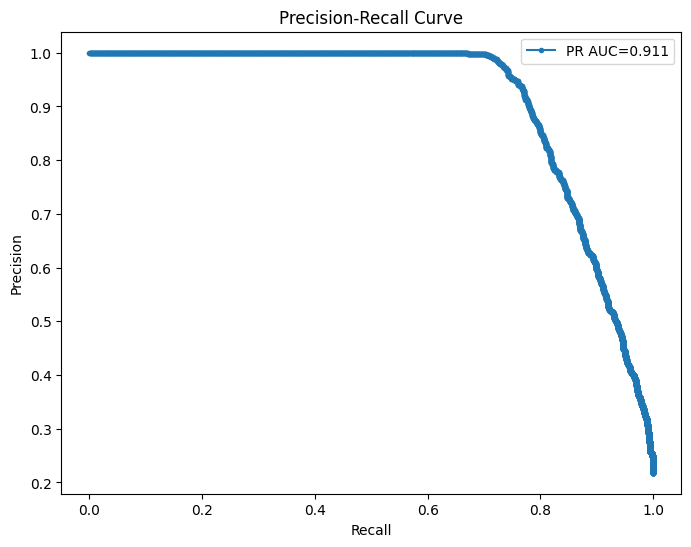

In [27]:
pr_auc = auc(recall, precision)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label=f'PR AUC={pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [28]:
predict = calibrated.predict(X_test)

print(f1_score(y_test, predict))
print(recall_score(y_test, predict))
print(precision_score(y_test, predict))

c:\Users\Даниэль\Desktop\Credit-scoring\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Даниэль\Desktop\Credit-scoring\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Даниэль\Desktop\Credit-scoring\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Даниэль\Desktop\Credit-scoring\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0.8382004735595896
0.7468354430379747
0.9550359712230215


c:\Users\Даниэль\Desktop\Credit-scoring\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [29]:
import joblib

joblib.dump(stacking_model, 'stacking_model.pkl')

['stacking_model.pkl']

In [ ]:
from sklearn.model_selection import StratifiedKFold



params_grid = {
    'modell__n_estimators': [100, 200, 300, 400, 500, 800],
    'modell__learning_rate': [0.01,0.03, 0.05,0.08 0.1],
    'modell__max_depth': [2, 3, 4, 5, 6],
    'modell__min_samples_split': [2, 5, 10],
    'modell__min_samples_leaf': [1, 3, 5],
    'modell__subsample': [0.8, 1.0]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = RandomizedSearchCV(
    estimator=gradient_model,
    param_distributions=params_grid,
    cv = cv,
    scoring='f1',
    verbose = 100,
    n_jobs=-1

)

grid.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,Pipeline(step...lassifier())])
,param_distributions,"{'modell__learning_rate': [0.01, 0.05, ...], 'modell__max_depth': [2, 3, ...], 'modell__min_samples_leaf': [1, 3, ...], 'modell__min_samples_split': [2, 5, ...], ...}"
,n_iter,10
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,100
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [37]:
best_model = grid.best_estimator_
predict = best_model.predict(X_test)

print(precision_score(y_test, predict))
print(recall_score(y_test, predict))
grid.best_params_

0.9652908067542214
0.7236286919831224


{'modell__subsample': 1.0,
 'modell__n_estimators': 300,
 'modell__min_samples_split': 2,
 'modell__min_samples_leaf': 5,
 'modell__max_depth': 4,
 'modell__learning_rate': 0.1}